# KUKA - Document Rectification
This jupyter notebook focus on Perspective rectification and background croping for document type A4,A5
These document may be has background or not ; present full document edges or not



### Reference
- https://dropbox.tech/machine-learning/fast-and-accurate-document-detection-for-scanning
- https://www.microsoft.com/en-us/research/uploads/prod/2016/12/Whiteboard-It.pdf
- https://stackoverflow.com/questions/7263621/how-to-find-corners-on-a-image-using-opencv
- https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

#### History
- 23-05-2023
    - select quadrangle with criterion base on paper: Complex document classifiaction adn localization application on Identity document images

In [1]:
import sys
import os
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, 'd:/Project/kuka-py/')
runingPath=os.path.abspath("")
parentPath = Path(runingPath).resolve().parents[0]
if(sys.path[0]!=parentPath):
    sys.path.insert(0, parentPath)

from kukalib.cardcrop  import  *
print(getVersionInfo())

{'version': '0.3.2', 'date': datetime.date(2023, 6, 19)}


## Load image

gray shape: (1600, 900)


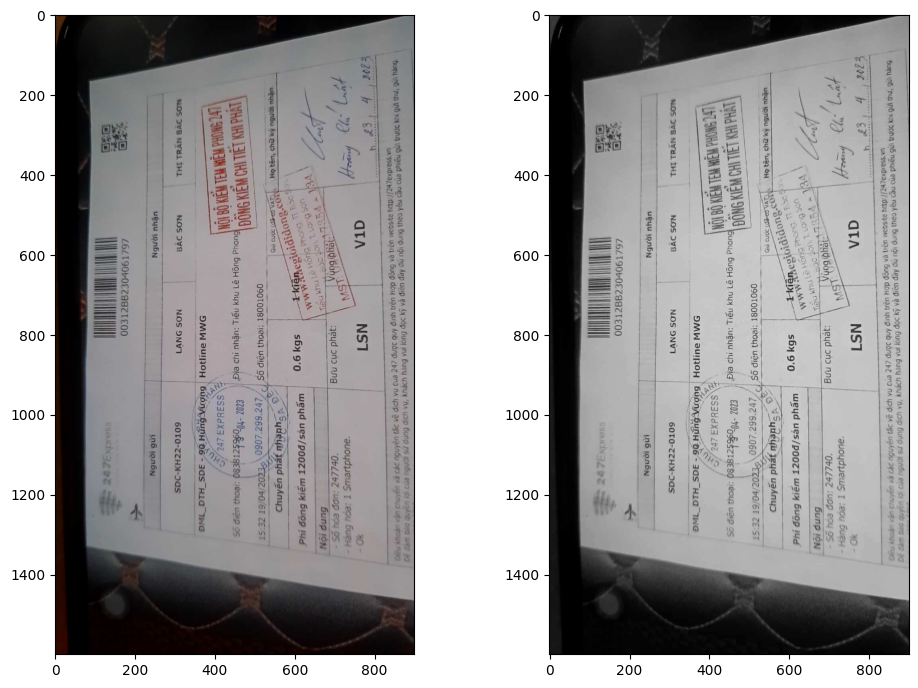

In [3]:


#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_23.jpg"
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_27.jpg"
filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train2\TB\img (32).jpg"


src=cv2.imread(filename)

gray=cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

print('gray shape:',gray.shape)
figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.show()

## Step 1: try to extract background
### using Morph_Close to remove text

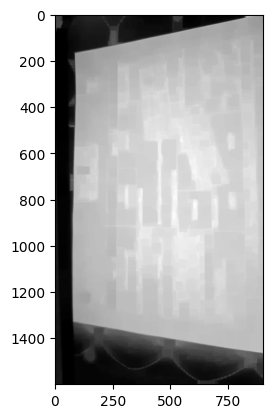

In [4]:
kernel=np.ones((7,7),np.uint8)
dilectImg=cv2.morphologyEx(src,cv2.MORPH_CLOSE,kernel,iterations=5)

gray=cv2.cvtColor(dilectImg,cv2.COLOR_BGR2GRAY)
    
blurImg=cv2.GaussianBlur(gray,(5,5),0)

plt.imshow(blurImg,cmap='gray')
plt.show()

## Step 2: edge and line detect

In [5]:
sobelImg=sobel(blurImg)
#sobelImg=cv2.Canny(blurImg,0,250,apertureSize=3)
ret1,edgeImg = cv2.threshold(sobelImg,40,200, cv2.THRESH_OTSU + cv2.THRESH_TOZERO + cv2.THRESH_BINARY)

## make egde more dilect
edgeImg=cv2.morphologyEx(edgeImg,cv2.MORPH_DILATE,(2,2),iterations=2)

linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)


Num of line hough probility: 82 - shape:  (82, 1, 4)


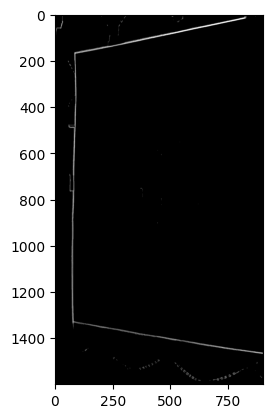

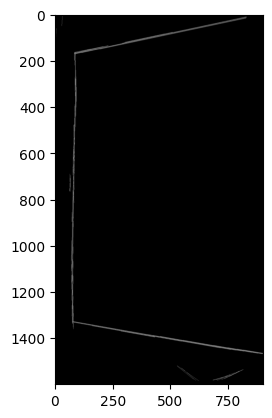

In [6]:
# print debug line
lineImg=np.zeros(src.shape,dtype=np.int8)
print('Num of line hough probility:', len(linesP), "- shape: " , linesP.shape )
for line in linesP:
    x1=line[0][0]
    y1=line[0][1]
    x2=line[0][2]
    y2=line[0][3]
    cv2.line(lineImg,(x1,y1),(x2,y2),(255,255,255),1)

plt.imshow(edgeImg,cmap='gray')
plt.show()
#plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.imshow(lineImg)
plt.show()

## Step 3: trying to find quadrilateral by estimating 4 lines: top/bottom , left/right
    Asumption:
        - card is nearly center of image
        - 4 edges of card nearly present in the image
    

## Dùng thuật toán đường biên dài nhất
1. Xác dịnh line => dùng houghp đề xác định các line với (x1,y1,x2,y2) => thresold = 1/5 * min(w,h)
2. Clustering lines into groups top / bottom / left/right
2. Fitting line / average line => for each group
    1. chuyển line (x1,y1,x2,y2) => về dạng slopes (b,m)
    2. grouping các line theo (b,m) + khoảng cách giữa các line => được danh sách tham chiếu [line_index] -> [line_in_group]
    3. duyệt theo danh sách tham chiếu => tạo các fitting line
    4. trả lại danh sách sau khi đã fitting
3. Tìm ra quadrangle 
    1. cluster => top/bottom/left/right
    2. soft t/b/l/r line theo length
    3. lấy ra 1 bộ (t,b,l,r) =>lựa chọn quadrangle thỏa mãn các điều kiện về góc va cạnh
- https://sbme-tutorials.github.io/2021/cv/notes/4_week4.html#getting-value-of-rho-and-theta
- https://dsp.stackexchange.com/questions/81992/how-to-convert-a-line-that-goes-through-the-origin-into-hough-space
- https://stackoverflow.com/questions/71811385/how-to-connect-disjointed-lines-or-edges-in-images

Merge line
- https://stackoverflow.com/questions/30746327/get-a-single-line-representation-for-multiple-close-by-lines-clustered-together
- https://answers.opencv.org/question/68781/partition-finding-the-number-of-clusters/


Lines top: [[ 83. 172.]
 [828.  13.]] bottom: [[  74. 1330.]
 [ 899. 1469.]] left: [[  86.  164.]
 [  78. 1354.]] right[[ 547. 1530.]
 [ 609. 1584.]]
Angle A:102.43	B:53.10	C:31.49	D:80.82
Criterion 1: min parallel angle:20 - Meet :False  
	Line angle of Top -12.00 - bottom 10.00  - left: 90.00 - right: 41.00 
Meet criterion 2: False
Meet criterion 3: True


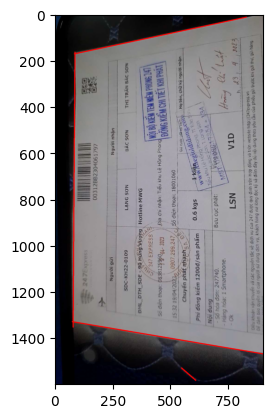

Lines top: [[ 83. 172.]
 [828.  13.]] bottom: [[  74. 1330.]
 [ 899. 1469.]] left: [[  88.  164.]
 [  71. 1190.]] right[[ 547. 1530.]
 [ 609. 1584.]]
Angle A:103.00	B:53.10	C:31.49	D:81.39
Criterion 1: min parallel angle:20 - Meet :False  
	Line angle of Top -12.00 - bottom 10.00  - left: 91.00 - right: 41.00 
Meet criterion 2: False
Meet criterion 3: True


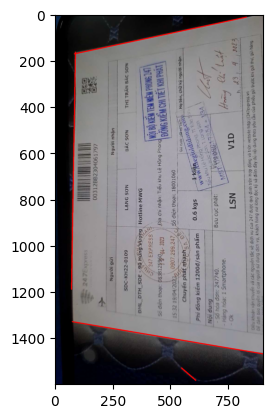

Lines top: [[ 83. 172.]
 [828.  13.]] bottom: [[  74. 1330.]
 [ 899. 1469.]] left: [[ 81. 535.]
 [ 64. 766.]] right[[ 547. 1530.]
 [ 609. 1584.]]
Angle A:106.26	B:53.10	C:31.49	D:84.65
Criterion 1: min parallel angle:20 - Meet :False  
	Line angle of Top -12.00 - bottom 10.00  - left: 94.00 - right: 41.00 
Meet criterion 2: False
Meet criterion 3: True


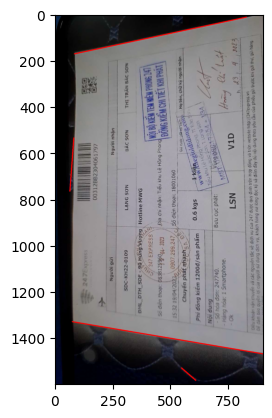

Lines top: [[ 83. 166.]
 [208. 140.]] bottom: [[  74. 1330.]
 [ 899. 1469.]] left: [[  86.  164.]
 [  78. 1354.]] right[[ 547. 1530.]
 [ 609. 1584.]]
Angle A:102.14	B:52.80	C:31.49	D:80.82
Criterion 1: min parallel angle:20 - Meet :False  
	Line angle of Top -12.00 - bottom 10.00  - left: 90.00 - right: 41.00 
Meet criterion 2: False
Meet criterion 3: True


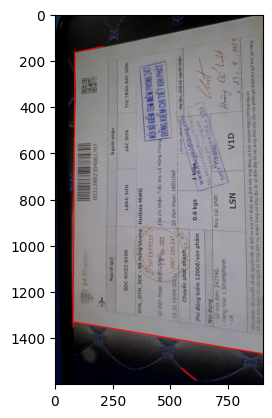

Lines top: [[ 83. 166.]
 [208. 140.]] bottom: [[  74. 1330.]
 [ 899. 1469.]] left: [[  88.  164.]
 [  71. 1190.]] right[[ 547. 1530.]
 [ 609. 1584.]]
Angle A:102.70	B:52.80	C:31.49	D:81.39
Criterion 1: min parallel angle:20 - Meet :False  
	Line angle of Top -12.00 - bottom 10.00  - left: 91.00 - right: 41.00 
Meet criterion 2: False
Meet criterion 3: True


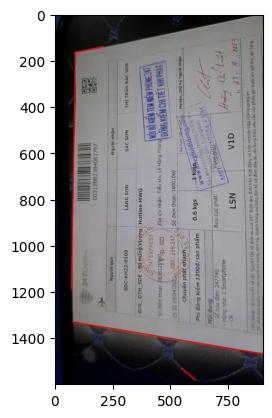

Lines top: [[ 83. 166.]
 [208. 140.]] bottom: [[  74. 1330.]
 [ 899. 1469.]] left: [[ 81. 535.]
 [ 64. 766.]] right[[ 547. 1530.]
 [ 609. 1584.]]
Angle A:105.96	B:52.80	C:31.49	D:84.65
Criterion 1: min parallel angle:20 - Meet :False  
	Line angle of Top -12.00 - bottom 10.00  - left: 94.00 - right: 41.00 
Meet criterion 2: False
Meet criterion 3: True


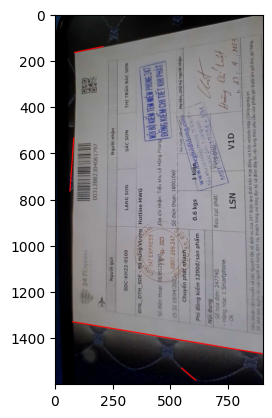

Can not crop document


In [7]:
def euclideanDistance(prop1,prop2):
    distance = math.sqrt(prop1*prop1+prop2*prop2)
    return distance

def clusteringLineInTBLR(lines,img_heigh,img_width):
    '''
        lines in shape (x1,y1,x2,y2)
        return list of top/bottom/left/right in separate
    '''
    toplineList=[]
    bottomlineList=[]
    leftlineList=[]
    rightlineList=[]

    xcenter=img_width/2
    ycenter=img_heigh/2
    # grouping lines in top,bottom,left,right

    for line in lines:
        p1=line[0][0:2]
        p2=line[0][2:4]
        angle= getLineAngle(p1,p2)
        linelength=getLineLength(p1,p2)
        angle=abs(angle)
        if(angle<40): # top/bottom line
            if(p1[1]+p2[1])/2 < ycenter:
                toplineList.append(line)
            elif (p1[1]+p2[1])/2 > ycenter:
                bottomlineList.append(line)
        else:
            if (p1[0]+p2[0])/2 < xcenter:
                leftlineList.append(line)
            elif (p1[0]+p2[0])/2 > xcenter:
                rightlineList.append(line)

    # converting list(object) to ndarray then sorting length by descending
    # if(len(toplineList) and len(bottomlineList) and len(leftlineList) and len(rightlineList)):
    #     toplineList = np.vstack(toplineList)
    #     bottomlineList = np.vstack(bottomlineList)
    #     leftlineList= np.vstack(leftlineList)
    #     rightlineList = np.vstack(rightlineList)
    
    toplineList = np.asarray(toplineList)
    bottomlineList = np.asarray(bottomlineList)
    leftlineList= np.asarray(leftlineList)
    rightlineList = np.asarray(rightlineList)

    return toplineList,bottomlineList,leftlineList,rightlineList

def sortLinePoint(lines,sort_axis):
    '''
        input lines in shape (num_line,4) each line is (x1,y1,x2,y2)
        sort_axis = 0 : sort by X otherwise sorting by Y
        perfome 2 sorting
            first sorting point P1,P1 in a line 
            second sorting line in lines  array
    '''
    #first sort
    assert(len(lines.shape)==2)
    for i in range(len(lines)):
        lineItem= lines[i].reshape(2,2)
        lineItem = lineItem[lineItem[:,sort_axis].argsort()]
        lines[i] = lineItem.reshape(1,4)
    #second sort
    lines = lines[lines[:,sort_axis].argsort()]

    return lines

def getLineLengthAngle(lines):
    '''
        add extra infomation length and angle to line in shape(num_line,4)
        return
            (x1,y1,x2,y2,length,angle)
    '''
    newList = []
    for line in lines:
        p1=line[0:2]
        p2=line[2:4]
        angle= getLineAngle(p1,p2)
        linelength=getLineLength(p1,p2)
        lineExtend=np.append(line[0:4],[round(linelength),round(angle)])
        newList.append(lineExtend)
    newList=np.asarray(newList)
    return newList

def drawLinePoint(img,linesP,lineColor,lineWidth):
  for line in linesP:
    x1=int(line[0])
    y1=int(line[1])
    x2=int(line[2])
    y2=int(line[3])
    cv2.line(img,(x1,y1),(x2,y2),lineColor,lineWidth) 

def convertLinePoint2Slope(linesP):
    '''
        convert line by 2 point (x1,y1,x2,y2) to format slope and y-intercept (mb) y=mx+b
        m = (x2-x1) / y2-y1 ; b = y1-mx1
    '''
    newList =[]
    for line in linesP:
        xDiff = line[2] - line[0]
        yDiff = line[3] - line[1]
        if(xDiff==0):
            m=0
            b=line[0]
        else:
            m = yDiff/xDiff
            b = line[1] - m*line[0]
        newline =[line[0],line[1],line[2],line[3],m,b]
        newList.append(newline)
    newList = np.asarray(newList)
    return newList

def convertLinePoint2RhoTheta(linesP):
    '''
        add roth and theta to line
        ref: https://math.stackexchange.com/questions/1796400/estimate-line-in-theta-rho-space-given-2-points
    '''
    newList = []
    for line in linesP:
        xDiff = line[2] - line[0]
        yDiff = line[3] - line[1]

        theta= math.atan2(yDiff,xDiff)

        if(xDiff==0):
            rho=line[0]
        else:
            m = yDiff/xDiff
             # r=|y1−mx1| / sqrt(m^2+1)
            rho = abs(line[1]-m*line[0]) / math.sqrt(m*m +1)
       
        newline =[line[0],line[1],line[2],line[3],rho,theta]
        newList.append(newline)
    newList = np.asarray(newList)
    return newList

def getFittingLine(lines,axis):
    '''
        input: lines in shape (x1,y1,x2,y2)
        axis = 0 then compare by X ; axis = 1 compare by Y
        return: a  line by minPoint() to maxPoint()
    '''
    #convert to shape (x,y)
    tempList = lines.reshape(len(lines)*2,2)
    minPoint = tempList[tempList[:,axis].argmin()]
    maxPoint = tempList[tempList[:,axis].argmax()]
    fitline=[minPoint[0],minPoint[1],maxPoint[0],maxPoint[1]]
    return fitline

def mergingLines(linesWithRhoTheta,rho_threshold,theta_threshold,max_gap,axis):
    '''
    input:
        - linesWithRhoTheta in shape(x1,y1,x2,y2,rho,theta)
        - axis = 1 join horizontal lines otherwise vertical lines
    '''
    num_line = len(linesWithRhoTheta)
    combineIndex=[]
    for i in range(num_line):
        combineIndex.append([])
    combineLines=[]
    max_threshold = euclideanDistance(rho_threshold,theta_threshold)
    for i in range(num_line):
        index = i
        for j in range(i,num_line):
            distanceI = linesWithRhoTheta[i][4]
            distanceJ = linesWithRhoTheta[j][4]
            slopeI =linesWithRhoTheta[i][5]
            slopeJ =linesWithRhoTheta[j][5]
            disDiff = abs(distanceI - distanceJ)
            slopeDiff = abs(slopeI-slopeJ)
            linedistance =euclideanDistance(slopeDiff,disDiff)
            canCombined=False
            
            if (linedistance<=max_threshold):
                canCombined=True
                if(i!=j):
                    if(axis==0):# check gap x
                        canCombined= (linesWithRhoTheta[j][0] - linesWithRhoTheta[i][2])<=max_gap
                    else: # check gap y
                        canCombined= (linesWithRhoTheta[j][1] - linesWithRhoTheta[i][3])<=max_gap
                        
            if canCombined:
                isCombined = False
                for w in range(i):
                    for u in range(len(combineIndex[w])):
                        if combineIndex[w][u] == j:
                            isCombined=True
                            break
                        if(combineIndex[w][u]==i): 
                            index =w
                    if(isCombined):
                        break
                if(not isCombined):
                   combineIndex[index].append(j)

    for i in range(len(combineIndex)):
        if(len(combineIndex[i])==0):
            continue
        tempLines=[]
        for j in range(len(combineIndex[i])):
            tempLines.append(linesWithRhoTheta[combineIndex[i][j]][0:4])

        tempLines = np.asarray(tempLines)
        fitline=getFittingLine(tempLines,axis)
        combineLines.append(fitline)

    combineLines=np.asarray(combineLines)    
    return combineLines

def getQuadrangleByLength(topLineList,bottomLineList,leftLineList,rightLineList):
    #get top 20% line only
    topLine=[]
    bottomLine=[]
    leftLine=[]
    rightLine=[]

    topLineList = getLineLengthAngle(topLineList)
    bottomLineList = getLineLengthAngle(bottomLineList)
    leftLineList = getLineLengthAngle(leftLineList)
    rightLineList = getLineLengthAngle(rightLineList)
    num_percent=0.2
    num_selected_line=0
    if(len(topLineList)*num_percent>1):
        num_selected_line=int(len(topLineList)*num_percent)
    else:
        num_selected_line=len(topLineList)
    topLineList = topLineList[topLineList[:,4].argsort()[::-1]][:num_selected_line]

    if(len(bottomLineList)*num_percent>1):
        num_selected_line=int(len(bottomLineList)*num_percent)
    else:
        num_selected_line=len(bottomLineList)
    bottomLineList = bottomLineList[bottomLineList[:,4].argsort()[::-1]][:num_selected_line]
    
    if(len(leftLineList)*num_percent>1):
        num_selected_line=int(len(leftLineList)*num_percent)
    else:
        num_selected_line= len(leftLineList)
    leftLineList = leftLineList[leftLineList[:,4].argsort()[::-1]][:num_selected_line]

    if(len(rightLineList)*num_percent>1):
        num_selected_line=int(len(rightLineList)*num_percent)
    else:
        num_selected_line=len(rightLineList)
    rightLineList = rightLineList[rightLineList[:,4].argsort()[::-1]][:num_selected_line]

    
    stopSearching = False
    numDebug=0
    selectedQuadrangleList=[]
    for tl in topLineList:
        if stopSearching: 
            break
        for bl in bottomLineList:
            if stopSearching:
                break
            for ll in leftLineList:
                if stopSearching:
                    break
                for rl in rightLineList:
                    numDebug+=1
                    showDebug = numDebug<=10
                    criterionResult,checkResult = verifyQuadrilateral(tl,bl,ll,rl,showDebug)
                    if(showDebug):
                        di = src.copy()
                        drawLinePoint(di,[tl,bl,ll,rl],(255,0,0),3)
                        plt.imshow(di)
                        plt.show()
                    if(checkResult):
                        selectedQuadrangleList.append([tl,bl,ll,rl])
                        stopSearching=checkResult
                    if stopSearching:
                        break

    if(len(selectedQuadrangleList)>0):
        q =selectedQuadrangleList[0]
        topLine=q[0].astype(int)
        bottomLine=q[1].astype(int)
        leftLine=q[2].astype(int)
        rightLine=q[3].astype(int)

    return topLine,bottomLine,leftLine,rightLine

def cropDocumentTest():
    img_height = gray.shape[0]
    img_width=gray.shape[1]

    rho_threshold =2 
    theta_threshold = 3*np.pi/180
    max_gap_x = int(0.05*img_width)
    max_gap_y = int(0.05*img_height)

    topLineList=[]
    bottomLineList=[]
    leftLineList=[]
    rightLineList=[]

    #get lines by hough
    linesP = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)    

    #clustering lines into 4 group
    topLineList,bottomLineList,leftLineList,rightLineList=clusteringLineInTBLR(linesP,img_height,img_width)
    hasCropped=False
    if (len(topLineList)>0 and len(bottomLineList)>0 and len(leftLineList)>0 and len(rightLineList)>0):
        
        # sort line in order befor merging
        topLineList = sortLinePoint(np.squeeze(topLineList,axis=1),sort_axis=0)
        bottomLineList = sortLinePoint( np.squeeze(bottomLineList,axis=1),sort_axis=0)

        leftLineList = sortLinePoint(np.squeeze(leftLineList,axis=1),sort_axis=1)
        rightLineList = sortLinePoint( np.squeeze(rightLineList,axis=1),sort_axis=1)

        #merging
        # convert to slope and merge
        topLineListRhoTheta = convertLinePoint2RhoTheta(topLineList)
        mergedTopLineList = mergingLines(topLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

        bottomLineListRhoTheta = convertLinePoint2RhoTheta(bottomLineList)
        mergedBottomLineList = mergingLines(bottomLineListRhoTheta,rho_threshold,theta_threshold,max_gap_x,axis=0)

        leftLineListRhoTheta = convertLinePoint2RhoTheta(leftLineList)
        mergedLeftLineList = mergingLines(leftLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

        rightLineListRhoTheta = convertLinePoint2RhoTheta(rightLineList)
        mergedRightLineList = mergingLines(rightLineListRhoTheta,rho_threshold,theta_threshold,max_gap_y,axis=1)

        
        topLine,bottomLine,leftLine,rightLine = getQuadrangleByLength(mergedTopLineList,mergedBottomLineList,mergedLeftLineList,mergedRightLineList)
        if(len(topLine)>0 and len(bottomLine)>0 and len(leftLine)>0 and len(rightLine)>0):
            cropedImg,lineImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint) = cropImage(src,topLine[0:4],bottomLine[0:4],leftLine[0:4],rightLine[0:4])
            hasCropped=True
            #display to check
            mergedLineImage = src.copy()
            drawLinePoint(mergedLineImage,mergedTopLineList,(0,0,255),3)
            drawLinePoint(mergedLineImage,mergedBottomLineList,(0,0,255),3)
            drawLinePoint(mergedLineImage,mergedLeftLineList,(0,0,255),3)
            drawLinePoint(mergedLineImage,mergedRightLineList,(0,0,255),3)

            plt.subplot(1,2,1)
            plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
            plt.subplot(1,2,2)
            plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
            plt.show()

    if(not hasCropped):
        print("Can not crop document")

cropDocumentTest()

## The Result above

# Test with SmartDoc Dataset

In [8]:
import xml.dom.minidom
import xml.etree.ElementTree as ET
from pathlib import Path 


In [9]:

def eval2Point(p1,p2):
    maxDis=30 # max distance from p1 to p2
    confident=0.0
    l=getLineLength(p1,p2)
    if(l<=maxDis):
        confident=((maxDis-l)/maxDis)
    return confident

def get_confidence_2quard(quadr_true,quadr_pred):
    (tl_pred,tr_pred,br_pred,bl_pred)=quadr_pred
    (tl,tr,br,bl)=quadr_true
    tl_c=(eval2Point(tl_pred,tl))
    tr_c=(eval2Point(tr_pred,tr))
    br_c=(eval2Point(br_pred,br))
    bl_c=(eval2Point(bl_pred,bl))

    mean_c=(tl_c+tr_c+br_c+bl_c)/4
    return mean_c


In [10]:
def getListGroundTruth(xmlfile):
    """
        returns:
            list frame points in order [tl,tr,br,bl]. 
    """
    gtList=[]
    doc = xml.dom.minidom.parse(xmlfile)
    frameList = doc.getElementsByTagName("frame")
    for frame in frameList:
        bl=[]
        tl=[]
        tr=[]
        br=[]
        pointList = frame.getElementsByTagName("point")
        for p in pointList:
            name = p.getAttribute("name")
            x= float(p.getAttribute("x"))
            y= float(p.getAttribute("y"))
            if(name=="bl"):
                bl = [x, y]
            elif name == "tl":
                tl =[x,y]
            elif name =="tr":
                tr =[x,y]
            elif name =="br":
                br=[x,y]
        gtList.append([tl,tr,br,bl])
    return gtList
    


videoFile =r"d:\ImageData\SmartDoc\background01\datasheet004.avi"
gtfile = r"D:\ImageData\SmartDoc\background01\datasheet004.gt.xml"

gtList =getListGroundTruth(gtfile)
gtList = np.asarray( gtList)

video = cv2.VideoCapture(videoFile)
videoName =Path(videoFile).name

# Check if camera opened successfully
if (video.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
numdebug=0
 
frame_width = int(video.get(3))
frame_height = int(video.get(4))
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter(r'D:/test/'+videoName,cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

frameIdx=0
confidenceList=[] 
while(video.isOpened()):
  # Capture frame-by-frame
  ret, frame = video.read()
  if ret == True:
    numdebug +=1
    frameIdx +=1
    
    cropedImg,debugImg,(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint),hasCropped=cropDocument(frame)
    (tl,tr,br,bl)=gtList[frameIdx-1]
    #calculate metric IoU
    confidence=get_confidence_2quard((tl,tr,br,bl),(topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint))
    print("Frame {} \t Confidence: {}".format(frameIdx,confidence))
    confidenceList.append(confidenceList)
    # Display the resulting frame
    out.write(debugImg)
    # if(numdebug<10):
    #    plt.imshow(debugImg)
    #    plt.show()
    # Press Q on keyboard to  exit
 
  # Break the loop
  else: 
    break

print('Confidence mean:',np.mean(confidenceList))

# When everything done, release the video capture object
video.release()
out.release()



Frame 1 	 Confidence: 0.431625718325652
Frame 2 	 Confidence: 0.4325411979875071
Frame 3 	 Confidence: 0.45725054832133816
Frame 4 	 Confidence: 0.4268942460670786
Frame 5 	 Confidence: 0.4533923820346183
Frame 6 	 Confidence: 0.4608835283411037
Frame 7 	 Confidence: 0.0
Frame 8 	 Confidence: 0.0
Frame 9 	 Confidence: 0.0
Frame 10 	 Confidence: 0.0
Frame 11 	 Confidence: 0.0
Frame 12 	 Confidence: 0.0
Frame 13 	 Confidence: 0.0
Frame 14 	 Confidence: 0.0
Frame 15 	 Confidence: 0.0
Frame 16 	 Confidence: 0.0
Frame 17 	 Confidence: 0.0
Frame 18 	 Confidence: 0.0
Frame 19 	 Confidence: 0.0
Frame 20 	 Confidence: 0.0
Frame 21 	 Confidence: 0.0
Frame 22 	 Confidence: 0.0
Frame 23 	 Confidence: 0.0
Frame 24 	 Confidence: 0.46254221400516915
Frame 25 	 Confidence: 0.4772763142755059
Frame 26 	 Confidence: 0.48334985583623663
Frame 27 	 Confidence: 0.8954492324668151
Frame 28 	 Confidence: 0.4637395272249526
Frame 29 	 Confidence: 0.4421417452697201
Frame 30 	 Confidence: 0.4524310194046275
Fr